# Exploratory data analysis for the flights data

### In this notebook, we explore the flights and airport data. We look at individual aspects of the flights and determine which features are useful for a predictive model. We have roughly taken these steps in the notebook:

1. Initial data exploration, checking for nulls, looking at visualizations to look at the possible features.
2. We then calculate the actual delay by subtracting `actualOffBlockTime`.
3. We then generate some potentially important features such as avg delay yesterday, avg delays at a given day 2 hours before a flight.
4. We also check for the counts of flights scheduled till 2 hours before the flight scheduled departure. 
5. To extract region information, we matched the airports data to flights data such that we obtained the destination region (which can be used as a feature in modelling).
6. We aggregate both the count and average features per terminal, region, overall.
7. Lastly, we define the target variable as binary, where a flight is considered delayed if the delay (as calculated above) is more than 10 minutes and not delayed, i.e. 0 when this delay is less than or equal to 10 minutes.


In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = "png"
pd.options.plotting.backend = "plotly"
pio.templates.default = "plotly_dark"
from IPython.display import display

In [2]:
import warnings
import os
warnings.filterwarnings("ignore")

DATASET_FOLDER = "../dataset"

In [3]:
airports_path = f"{DATASET_FOLDER}/airports.csv" 
flights_path = f"{DATASET_FOLDER}/flights.csv"      

df_airports = pd.read_csv(airports_path)
df_flights = pd.read_csv(flights_path)

print(f"Airports data shape: {df_airports.shape}")
print(f"Flights data shape: {df_flights.shape}")

Airports data shape: (7184, 14)
Flights data shape: (523275, 28)


In [4]:
display(df_flights.head())
print(df_flights.columns)
display(df_flights.describe())

,actualOffBlockTime,aircraftRegistration,aircraftType.iatamain,aircraftType.iatasub,airlineCode,baggageClaim,estimatedLandingTime,expectedTimeBoarding,expectedTimeGateClosing,expectedTimeGateOpen,...,prefixICAO,publicEstimatedOffBlockTime,publicFlightState.flightStates,route.destinations,scheduleDate,scheduleTime,serviceType,terminal,transferPositions,transferPositions.transferPositions
0,NaN,NaN,NaN,NaN,148.0,NaN,NaN,NaN,NaN,NaN,...,ZXP,NaN,['SCH'],['AMS'],2018-01-01,03:02:07,P,NaN,NaN,NaN
1,NaN,PHPXY,AW1,NaN,148.0,NaN,NaN,NaN,NaN,NaN,...,ZXP,NaN,['SCH'],['AMS'],2018-01-01,03:16:00,NaN,NaN,NaN,NaN
2,NaN,NaN,AW1,NaN,148.0,NaN,NaN,NaN,NaN,NaN,...,ZXP,NaN,['SCH'],['AMS'],2018-01-01,03:16:29,P,NaN,NaN,NaN
3,2018-01-01T03:22:00.000+01:00,PHPXB,NaN,NaN,148.0,NaN,NaN,NaN,NaN,NaN,...,ZXP,NaN,['DEP'],['AMS'],2018-01-01,03:30:00,NaN,NaN,NaN,NaN
4,2018-01-01T05:58:22.000+01:00,PHHSJ,73H,73H,164.0,NaN,NaN,NaN,NaN,NaN,...,TRA,NaN,['DEP'],['SPC'],2018-01-01,06:00:00,J,1.0,NaN,NaN


Index(['actualOffBlockTime', 'aircraftRegistration', 'aircraftType.iatamain',
       'aircraftType.iatasub', 'airlineCode', 'baggageClaim',
       'estimatedLandingTime', 'expectedTimeBoarding',
       'expectedTimeGateClosing', 'expectedTimeGateOpen', 'expectedTimeOnBelt',
       'flightDirection', 'flightName', 'flightNumber', 'gate', 'id',
       'mainFlight', 'prefixIATA', 'prefixICAO', 'publicEstimatedOffBlockTime',
       'publicFlightState.flightStates', 'route.destinations', 'scheduleDate',
       'scheduleTime', 'serviceType', 'terminal', 'transferPositions',
       'transferPositions.transferPositions'],
      dtype='object')


,airlineCode,baggageClaim,estimatedLandingTime,expectedTimeOnBelt,flightNumber,id,terminal,transferPositions
count,521867.000000,0.0,0.0,0.0,521572.000000,5.232750e+05,494629.000000,0.0
mean,805.384765,NaN,NaN,NaN,5431.027120,1.241429e+17,1.581781,NaN
std,1319.735519,NaN,NaN,NaN,3416.845675,4.055064e+14,0.668756,NaN
min,6.000000,NaN,NaN,NaN,0.000000,1.234004e+17,1.000000,NaN
25%,64.000000,NaN,NaN,NaN,1731.000000,1.238009e+17,1.000000,NaN
50%,100.000000,NaN,NaN,NaN,6147.000000,1.241591e+17,1.000000,NaN
75%,1294.000000,NaN,NaN,NaN,8638.000000,1.244893e+17,2.000000,NaN
max,5108.000000,NaN,NaN,NaN,9999.000000,1.248968e+17,3.000000,NaN


In [5]:
display(df_airports.head())
print(df_airports.columns)
display(df_airports.describe())

,Airport,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Tz,Type,Source
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,U,Pacific/Port_Moresby,airport,OurAirports
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10,U,Pacific/Port_Moresby,airport,OurAirports
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby,airport,OurAirports
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10,U,Pacific/Port_Moresby,airport,OurAirports


Index(['Airport', 'Name', 'City', 'Country', 'IATA', 'ICAO', 'Latitude',
       'Longitude', 'Altitude', 'Timezone', 'DST', 'Tz', 'Type', 'Source'],
      dtype='object')


,Airport,Latitude,Longitude,Altitude
count,7184.000000,7184.000000,7184.000000,7184.000000
mean,4672.248886,25.950874,-2.946702,1011.833101
std,3324.796152,28.239954,85.993653,1608.349308
min,1.000000,-90.000000,-179.876999,-1266.000000
25%,1853.750000,7.366353,-79.467924,66.000000
50%,3809.500000,34.262400,5.820455,354.000000
75%,7187.250000,47.290104,50.838224,1197.250000
max,12057.000000,82.517799,179.951004,14219.000000


In [6]:
print(f"Flights info:\n {df_flights.info()}")
print(f"Airports info:\n {df_airports.info()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 523275 entries, 0 to 523274
Data columns (total 28 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   actualOffBlockTime                   487716 non-null  object 
 1   aircraftRegistration                 495732 non-null  object 
 2   aircraftType.iatamain                521108 non-null  object 
 3   aircraftType.iatasub                 518308 non-null  object 
 4   airlineCode                          521867 non-null  float64
 5   baggageClaim                         0 non-null       float64
 6   estimatedLandingTime                 0 non-null       float64
 7   expectedTimeBoarding                 426919 non-null  object 
 8   expectedTimeGateClosing              426919 non-null  object 
 9   expectedTimeGateOpen                 414178 non-null  object 
 10  expectedTimeOnBelt                   0 non-null       float64
 11  flightDirecti

### What kind of flights do we have

publicFlightState.flightStates
['DEP']                  432160
['DEP', 'DEL']            55613
['SCH']                   23309
['CNX']                   11237
['SCH', 'GCH']              476
['GCL', 'GCH']              102
['GCL']                      59
['SCH', 'GCH', 'DEL']        54
['GTD']                      43
['GTO', 'GCH']               41
['BRD']                      40
['GTO']                      33
[]                           25
['WIL']                      24
['BRD', 'GCH']               19
['SCH', 'DEL']               10
['BRD', 'GCH', 'DEL']        10
['GTO', 'GCH', 'DEL']         8
['GTD', 'DEL']                6
['GCL', 'GCH', 'DEL']         3
['WIL', 'DEL']                2
['BRD', 'DEL']                1
Name: count, dtype: int64


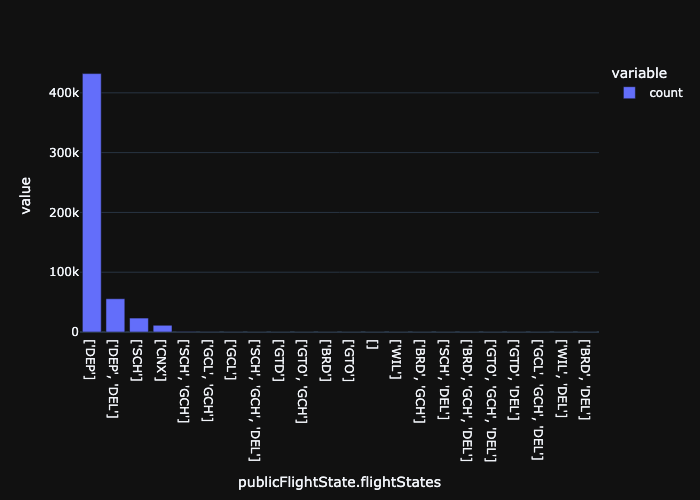

In [7]:
print(df_flights["publicFlightState.flightStates"].value_counts())
df_flights["publicFlightState.flightStates"].value_counts().plot.bar()

### Delay calculation and visualisation

In [12]:
# Combine scheduleDate and scheduleTime into one datetime column for scheduled departure
df_flights['scheduledDeparture'] = pd.to_datetime(df_flights['scheduleDate'] + ' ' + df_flights['scheduleTime'])
df_flights['scheduledDeparture'] = df_flights['scheduledDeparture'].dt.tz_localize('UTC+01:00')
df_flights['actualOffBlockTime'] = pd.to_datetime(df_flights['actualOffBlockTime'], errors='coerce')

In [13]:
# Compute delay in minutes (difference between actual and scheduled departure)
df_flights['delay_minutes'] = (df_flights['actualOffBlockTime'] - df_flights['scheduledDeparture']).dt.total_seconds() / 60

raw_data_len = len(df_flights)
print(f"Total flights before dropping NA delays: {raw_data_len}")
df_flights.dropna(subset=['delay_minutes'], inplace=True)
print(f"Total flights after dropping NA delays: {raw_data_len - len(df_flights)}")
print(f"Percentage of entries dropped: {(1 - len(df_flights) / raw_data_len) * 100:.2f}%")

# we treat early departures as zero delay
df_flights['delay_minutes'] = df_flights['delay_minutes'].apply(lambda x: x if x > 0 else 0)

print(df_flights['delay_minutes'].describe())

Total flights before dropping NA delays: 523275
Total flights after dropping NA delays: 329270
Percentage of entries dropped: 62.92%
count    194005.000000
mean         14.662993
std          48.029228
min           0.000000
25%           1.216667
50%           6.000000
75%          14.983333
max        4685.350000
Name: delay_minutes, dtype: float64


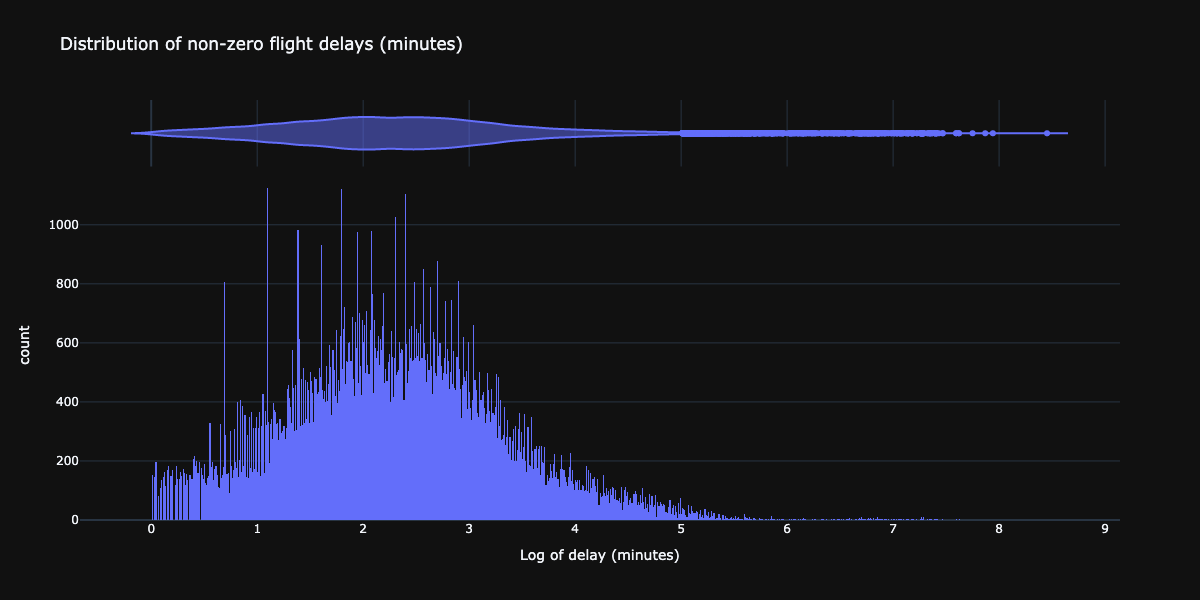

In [14]:
df_flights["delay_minutes_log"] = np.log1p(df_flights["delay_minutes"])
non_zero_delays = df_flights[df_flights['delay_minutes_log'] > 0]

fig1 = px.histogram(
    non_zero_delays, 
    x='delay_minutes_log', 
    nbins=1500, 
    title="Distribution of non-zero flight delays (minutes)",
    labels={'delay_minutes_log': 'Log of delay (minutes)'},
    marginal="violin",
)
fig1.update_layout(
    width=1200,
    height=600,  
)
fig1.show()

#### Delay ranges across data

In [15]:
delay_counts = df_flights['delay_minutes'].apply(lambda x: 'no_delay' if x == 0 else 'less_than_10_minutes_delay' if x <= 10 else 'more_than_10_minutes_delay').value_counts()
display(delay_counts)

# Calculate and display the class imbalance percentage
total_flights = delay_counts.sum()
no_delay_percentage = (delay_counts['no_delay'] / total_flights) * 100
zero_delay_percentage = (delay_counts['less_than_10_minutes_delay'] / total_flights) * 100
non_zero_delay_percentage = (delay_counts['more_than_10_minutes_delay'] / total_flights) * 100


print(f"Percentage of flights with no delay: {no_delay_percentage:.2f}%")
print(f"Percentage of flights with less_than_10_minutes delay: {zero_delay_percentage:.2f}%")
print(f"Percentage of flights with more_than_10_minutes delay: {non_zero_delay_percentage:.2f}%")


delay_minutes
less_than_10_minutes_delay    87107
more_than_10_minutes_delay    70235
no_delay                      36663
Name: count, dtype: int64

Percentage of flights with no delay: 18.90%
Percentage of flights with less_than_10_minutes delay: 44.90%
Percentage of flights with more_than_10_minutes delay: 36.20%


### Flight departures and delays dependency on the departure region
- We check and assign a separate column to the first destination the flights flew to.
- We use the airport.csv to extract the region (Pacific, Europe etc.) to which the flights in flights data flew to (using IATA, ICAO prefixes)

In [16]:
df_flights['num_destinations'] = df_flights['route.destinations'].apply(lambda x: len(eval(x)) if isinstance(x, str) else 0)
df_flights['first_destination'] = df_flights['route.destinations'].apply(lambda x: eval(x)[0] if isinstance(x, str) and len(eval(x)) > 0 else None)

df_merged = pd.merge(
    df_flights, 
    df_airports, 
    how='left',
    left_on='first_destination', 
    right_on='IATA',
    suffixes=('', '_airport')
).dropna(subset=['IATA'])

# Now extract top-level region from something like "Europe/Paris" -> "Europe"
df_merged['region'] = df_merged['Tz'].str.split("/").str.get(0)

In [17]:
pd.set_option('display.max_columns', None)
display(df_merged.head())

,actualOffBlockTime,aircraftRegistration,aircraftType.iatamain,aircraftType.iatasub,airlineCode,baggageClaim,estimatedLandingTime,expectedTimeBoarding,expectedTimeGateClosing,expectedTimeGateOpen,expectedTimeOnBelt,flightDirection,flightName,flightNumber,gate,id,mainFlight,prefixIATA,prefixICAO,publicEstimatedOffBlockTime,publicFlightState.flightStates,route.destinations,scheduleDate,scheduleTime,serviceType,terminal,transferPositions,transferPositions.transferPositions,scheduledDeparture,delay_minutes,delay_minutes_log,num_destinations,first_destination,Airport,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Tz,Type,Source,region
0,2018-01-01 03:22:00+01:00,PHPXB,NaN,NaN,148.0,NaN,NaN,NaN,NaN,NaN,NaN,D,ZXP022,22.0,NaN,123414481790510775,ZXP022,NaN,ZXP,NaN,['DEP'],['AMS'],2018-01-01,03:30:00,NaN,NaN,NaN,NaN,2018-01-01 03:30:00+01:00,0.000000,0.000000,1,AMS,580.0,Amsterdam Airport Schiphol,Amsterdam,Netherlands,AMS,EHAM,52.308601,4.76389,-11.0,1,E,Europe/Amsterdam,airport,OurAirports,Europe
1,2018-01-01 05:58:22+01:00,PHHSJ,73H,73H,164.0,NaN,NaN,NaN,NaN,NaN,NaN,D,HV5641,5641.0,D59,123414479288269149,HV5641,HV,TRA,NaN,['DEP'],['SPC'],2018-01-01,06:00:00,J,1.0,NaN,NaN,2018-01-01 06:00:00+01:00,0.000000,0.000000,1,SPC,1053.0,La Palma Airport,Santa Cruz De La Palma,Spain,SPC,GCLA,28.626499,-17.75560,107.0,0,E,Atlantic/Canary,airport,OurAirports,Atlantic
2,2018-01-01 06:00:00+01:00,PHHSG,73H,73H,100.0,NaN,NaN,NaN,NaN,NaN,NaN,D,KL2533,2533.0,D86,123414479666542945,HV6455,KL,KLM,NaN,['DEP'],['LPA'],2018-01-01,06:05:00,J,1.0,NaN,NaN,2018-01-01 06:05:00+01:00,0.000000,0.000000,1,LPA,1054.0,Gran Canaria Airport,Gran Canaria,Spain,LPA,GCLP,27.931900,-15.38660,78.0,0,E,Atlantic/Canary,airport,OurAirports,Atlantic
3,2018-01-01 06:00:00+01:00,PHHSG,73H,73H,164.0,NaN,NaN,NaN,NaN,NaN,NaN,D,HV6455,6455.0,D86,123414479288365061,HV6455,HV,TRA,NaN,['DEP'],['LPA'],2018-01-01,06:05:00,J,1.0,NaN,NaN,2018-01-01 06:05:00+01:00,0.000000,0.000000,1,LPA,1054.0,Gran Canaria Airport,Gran Canaria,Spain,LPA,GCLP,27.931900,-15.38660,78.0,0,E,Atlantic/Canary,airport,OurAirports,Atlantic
4,2018-01-01 06:26:34+01:00,PHHXB,73H,73H,164.0,NaN,NaN,NaN,NaN,NaN,NaN,D,HV5801,5801.0,E08,123414479288274329,HV5801,HV,TRA,NaN,['DEP'],['TLV'],2018-01-01,06:15:00,J,1.0,NaN,NaN,2018-01-01 06:15:00+01:00,11.566667,2.531048,1,TLV,1590.0,Ben Gurion International Airport,Tel-aviv,Israel,TLV,LLBG,32.011398,34.88670,135.0,2,E,Asia/Jerusalem,airport,OurAirports,Asia


#### Visualise the distribution of delays by region
- We visualise the distribution on a log scale to fully see the extremely long tailed outliers

In [18]:

df_merged['delay_minutes'] = df_merged['delay_minutes'].clip(lower=0)
df_merged['log_delay'] = np.log1p(df_merged['delay_minutes'])

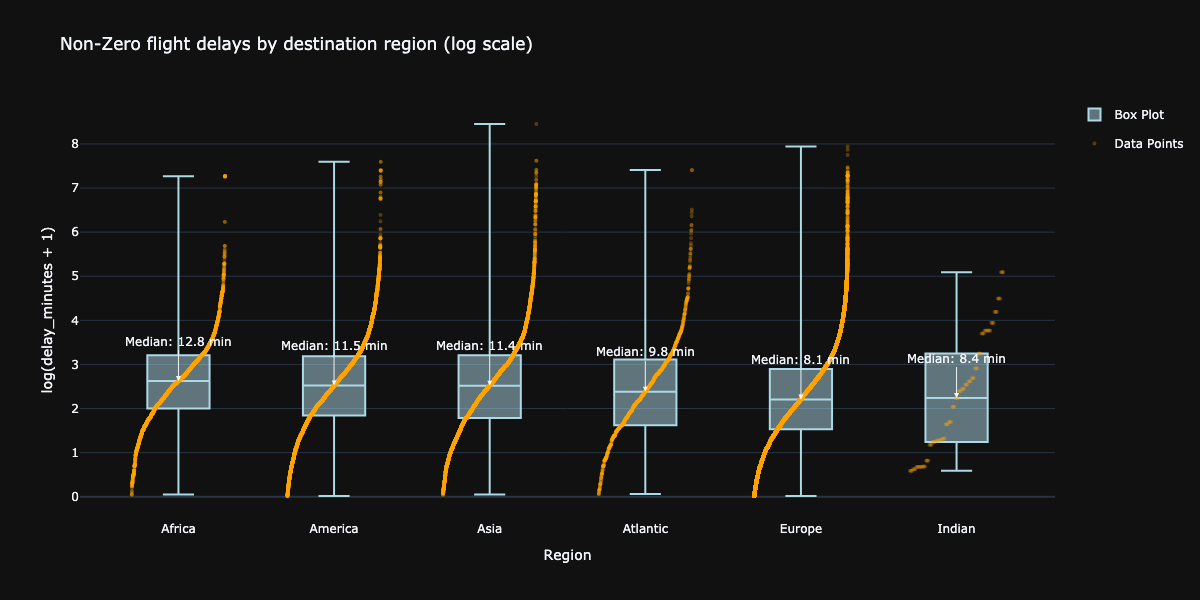

In [19]:
# Filter out \N region and sort remaining regions (I dont know what this is so I wont use it!)
regions_sorted = sorted([reg for reg in df_merged['region'].dropna().unique() if reg != '\\N'])
region_to_num = {reg: i for i, reg in enumerate(regions_sorted)}

fig = go.Figure()

for idx, reg in enumerate(regions_sorted):
    subset = df_merged[(df_merged['region'] == reg) & (df_merged['log_delay'] > 0)]
    

    median_delay = subset['delay_minutes'].median()
    
    fig.add_trace(go.Box(
        x=[region_to_num[reg]] * len(subset),
        y=subset['log_delay'],
        name="Box Plot" if idx == 0 else None,
        legendgroup="BoxPlot",
        showlegend=(idx==0),
        boxpoints=False,
        marker_color='lightblue',
        line_color='lightblue',
        quartilemethod="linear",
        width=0.4
    ))
    
    # Sort the data points and compute evenly spaced jitter for x positions
    sorted_y = np.sort(subset['log_delay'])
    jitter = np.linspace(-0.3, 0.3, len(sorted_y))
    x_positions = region_to_num[reg] + jitter
    
    # Add Scatter trace for sorted data points overlay
    fig.add_trace(go.Scatter(
        x=x_positions,
        y=sorted_y,
        mode='markers',
        name="Data Points" if idx == 0 else None,
        legendgroup="Scatter",
        showlegend=(idx==0),
        marker=dict(color='orange', size=4, opacity=0.3)
    ))
    
    # Add annotation for median delay
    fig.add_annotation(
        x=region_to_num[reg],
        y=np.log1p(median_delay),  # Convert median delay to log scale for positioning
        text=f"Median: {median_delay:.1f} min",
        showarrow=True,
        arrowhead=2,
        ax=0,
        ay=-40
    )

fig.update_layout(
    title="Non-Zero flight delays by destination region (log scale)",
    xaxis=dict(
        title="Region",
        tickmode='array',
        tickvals=list(region_to_num.values()),
        ticktext=list(region_to_num.keys())
    ),
    yaxis=dict(
        title="log(delay_minutes + 1)"
    ),
    boxmode='group',
    width=1200,
    height=600,
)

fig.show()

## Exploring Features

### Static flight features

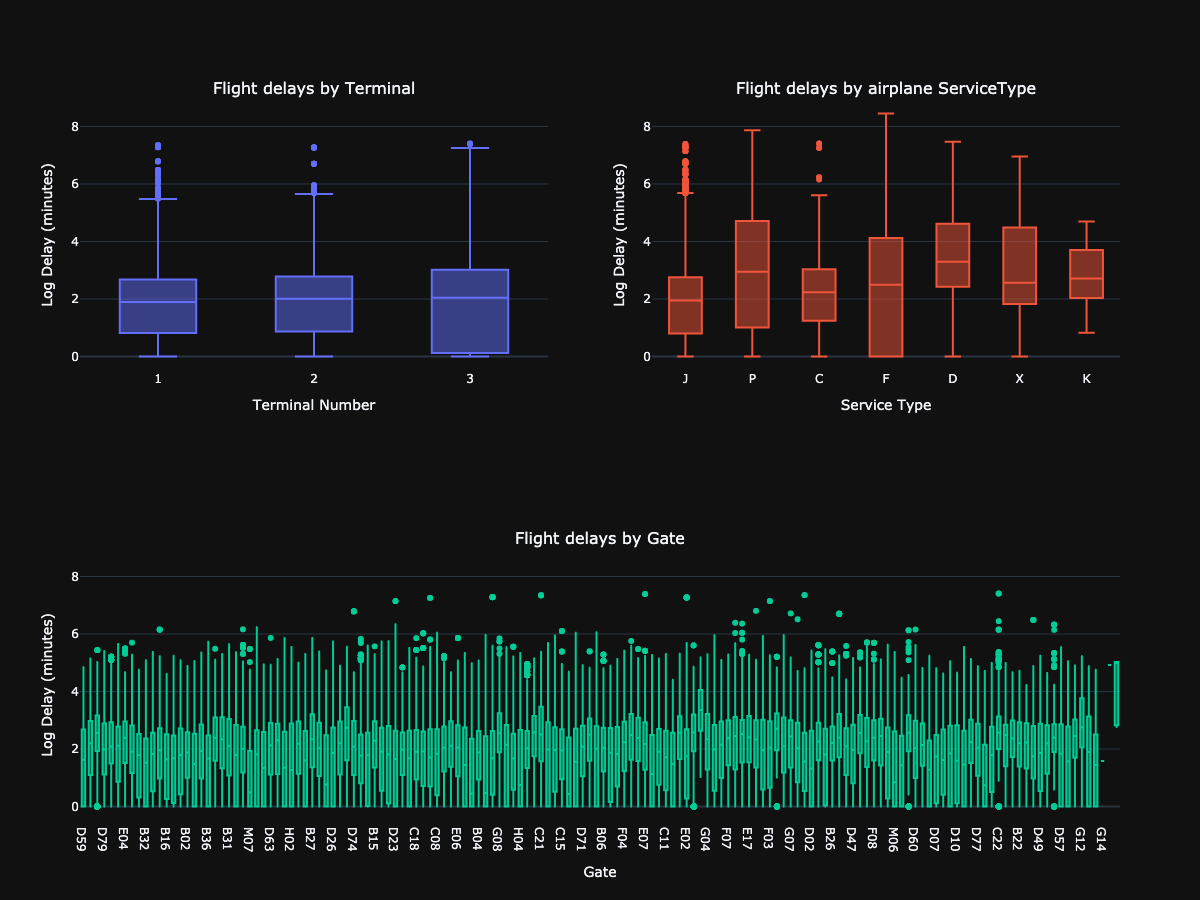

In [20]:
# interesting static features
static_features = [
    'serviceType', 
    'terminal', 
    'gate', 
]

fig = make_subplots(rows=2, cols=2, 
                    subplot_titles=["Flight delays by Terminal", "Flight delays by airplane ServiceType", "Flight delays by Gate"],
                    specs=[[{}, {}],
                          [{"colspan": 2}, None]])


fig.add_trace(
    go.Box(
        x=df_merged['terminal'],
        y=df_merged['log_delay'],
        name='Terminal'
    ),
    row=1, col=1
)
fig.add_trace(
    go.Box(
        x=df_merged['serviceType'],
        y=df_merged['log_delay'],
        name='Service Type'
    ),
    row=1, col=2
)
fig.add_trace(
    go.Box(
        x=df_merged['gate'],
        y=df_merged['log_delay'],
        name='Gate'
    ),
    row=2, col=1
)


fig.update_layout(
    height=900,
    width=1200,
    showlegend=False
)

# Update axes labels
fig.update_xaxes(title_text='Terminal Number', row=1, col=1)
fig.update_xaxes(title_text='Service Type', row=1, col=2)
fig.update_xaxes(title_text='Gate', row=2, col=1)
fig.update_yaxes(title_text='Log Delay (minutes)', row=1, col=1)
fig.update_yaxes(title_text='Log Delay (minutes)', row=1, col=2)
fig.update_yaxes(title_text='Log Delay (minutes)', row=2, col=1)

fig.show()

### Temporal flight features
#### Delays by the designated scheduled departure hour and day

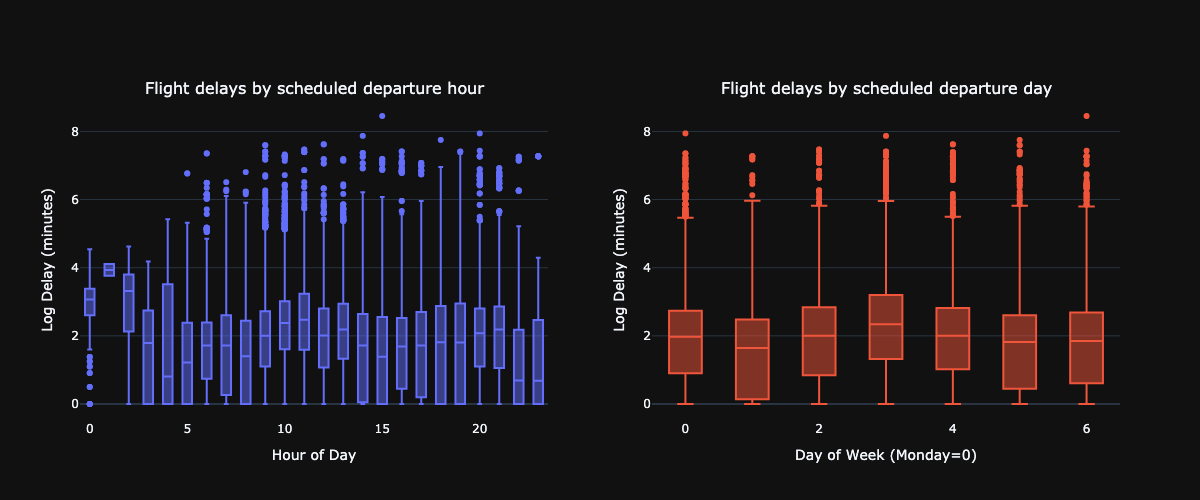

In [21]:
fig = make_subplots(rows=1, cols=2, 
                    subplot_titles=["Flight delays by scheduled departure hour", "Flight delays by scheduled departure day"])


df_merged['hour'] = df_merged['scheduledDeparture'].dt.hour
fig.add_trace(
    go.Box(
        x=df_merged['hour'],
        y=df_merged['log_delay'],
        name='Hour'
    ),
    row=1, col=1
)
df_merged['day_of_week'] = df_merged['scheduledDeparture'].dt.dayofweek
fig.add_trace(
    go.Box(
        x=df_merged['day_of_week'],
        y=df_merged['log_delay'],
        name='Day of Week'
    ),
    row=1, col=2
)


fig.update_layout(
    height=500,
    width=1200,
    showlegend=False
)
fig.update_xaxes(title_text='Hour of Day', row=1, col=1)
fig.update_xaxes(title_text='Day of Week (Monday=0)', row=1, col=2)
fig.update_yaxes(title_text='Log Delay (minutes)', row=1, col=1)
fig.update_yaxes(title_text='Log Delay (minutes)', row=1, col=2)

fig.show()

### Temporal lag and aggregated features
- Are delays for a given flight dependent on the delays in flights 2,4, and 8 hours before scheduled departure? On the same terminal? Overall on airport?
- Are delays for a given flight dependent on the average delay till 2 hours before the scheduled departure on the same terminal? overall?
- Are delays for a given flight dependent on the number of flights that have flown till 2 hours before the scheduled departure on the same terminal? Overall?

#### First we compute the lag features corresponding to average delays 2,4, and 8 hours and  before the scheduled departure

In [22]:
df_merged_copy = df_merged.copy()
df_merged_copy = df_merged_copy.sort_values("scheduledDeparture")


df_merged_copy['scheduledDeparture'] = pd.to_datetime(df_merged_copy['scheduledDeparture'])
df_merged_copy['departure_bin'] = df_merged_copy['scheduledDeparture'].dt.round('60min')

# 2. Compute the average delay per bin (this is our reference for the typical delay at that time)
bin_avg = df_merged_copy.groupby('departure_bin')['delay_minutes'].mean()

# 3. For each flight, compute the target times:
df_merged_copy['target_time_2h'] = df_merged_copy['scheduledDeparture'] - pd.Timedelta(hours=3)
df_merged_copy['target_time_12h'] = df_merged_copy['scheduledDeparture'] - pd.Timedelta(hours=12)
df_merged_copy['target_time_1d'] = df_merged_copy['scheduledDeparture'] - pd.Timedelta(days=1)

# 4. Round these target times to the nearest 15 minutes so that they match our bins.
df_merged_copy['target_bin_2h'] = df_merged_copy['target_time_2h'].dt.round('60min')
df_merged_copy['target_bin_12h'] = df_merged_copy['target_time_1d'].dt.round('60min')
df_merged_copy['target_bin_1d'] = df_merged_copy['target_time_1d'].dt.round('60min')

# 5. Map the computed bin averages onto these target bins to create our new features.
df_merged_copy['lag_avg_delay_2h_overall'] = df_merged_copy['target_bin_2h'].map(bin_avg)
df_merged_copy['lag_avg_delay_12h_overall'] = df_merged_copy['target_bin_12h'].map(bin_avg)
df_merged_copy['lag_avg_delay_1d_overall'] = df_merged_copy['target_bin_1d'].map(bin_avg)

# Optionally, drop the intermediate columns if you don't need them:
cols_to_drop = ['departure_bin', 'target_time_2h', 'target_time_12h', 'target_time_1d', 'target_bin_2h','target_bin_12h', 'target_bin_1d']
df_merged_copy.drop(columns=cols_to_drop, inplace=True)

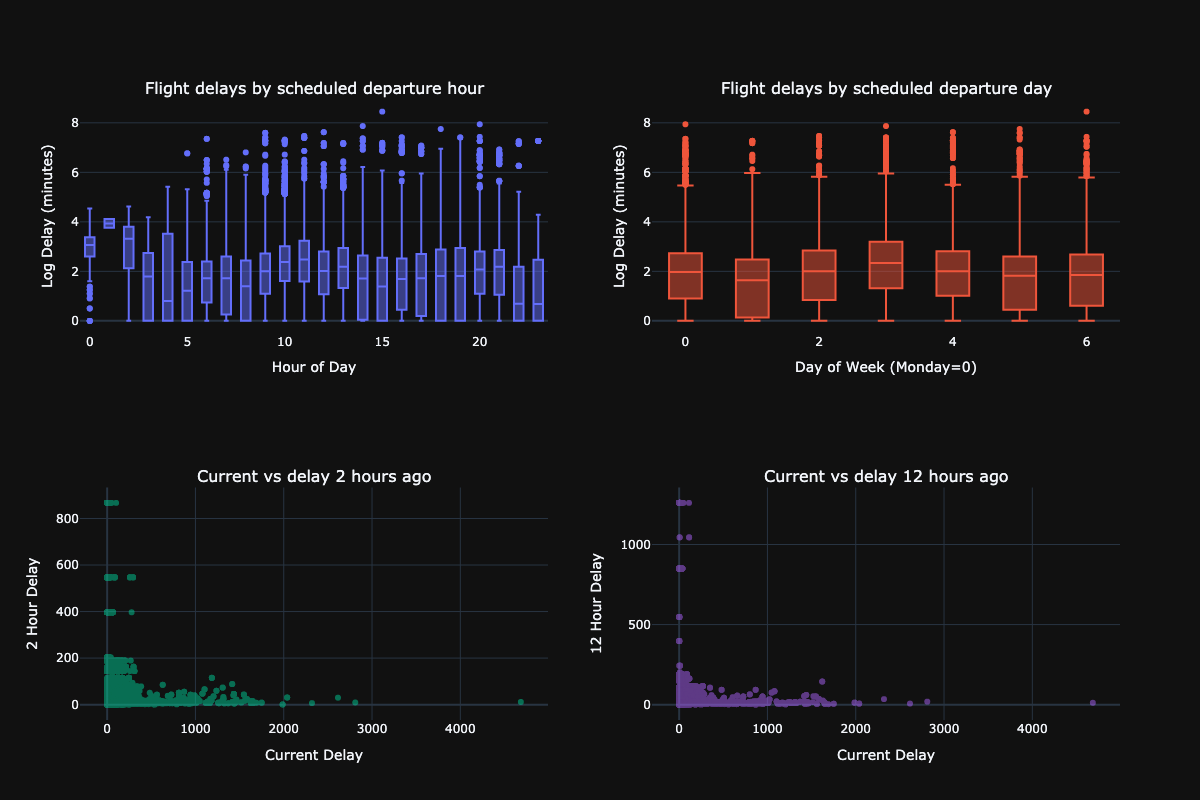

In [24]:
fig = make_subplots(rows=2, cols=2, 
                    subplot_titles=["Flight delays by scheduled departure hour",
                                    "Flight delays by scheduled departure day",
                                    "Current vs delay 2 hours ago",
                                    "Current vs delay 12 hours ago"])


fig.add_trace(
    go.Box(
        x=df_merged_copy['hour'],
        y=df_merged_copy['log_delay'],
        name='Hour'
    ),
    row=1, col=1
)
fig.add_trace(
    go.Box(
        x=df_merged_copy['day_of_week'],
        y=df_merged_copy['log_delay'],
        name='Day'
    ),
    row=1, col=2
)
fig.add_trace(
    go.Scatter(
        x=df_merged_copy['delay_minutes'],
        y=df_merged_copy['lag_avg_delay_2h_overall'],
        mode='markers',
        opacity=0.5,
        name='2 hour Lag'
    ),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(
        x=df_merged_copy['delay_minutes'],
        y=df_merged_copy['lag_avg_delay_12h_overall'],
        mode='markers',
        opacity=0.5,
        name='8 hour Lag'
    ),
    row=2, col=2
)

fig.update_layout(
    height=800,
    width=1200,
    showlegend=False,
)
fig.update_xaxes(title_text='Hour of Day', row=1, col=1)
fig.update_xaxes(title_text='Day of Week (Monday=0)', row=1, col=2)
fig.update_xaxes(title_text='Current Delay', row=2, col=1)
fig.update_xaxes(title_text='Current Delay', row=2, col=2)
fig.update_yaxes(title_text='Log Delay (minutes)', row=1, col=1)
fig.update_yaxes(title_text='Log Delay (minutes)', row=1, col=2)
fig.update_yaxes(title_text='2 Hour Delay', row=2, col=1)
fig.update_yaxes(title_text='12 Hour Delay', row=2, col=2)

fig.show()

#### Aggregated features
- Are current delays dependent on average delays that day till 2 hours before that day ? per terminal, per region, overall?
- Are current delays dependent on the count of flights departed till that 2 hours before that day? per terminal, per region, overall?

In [25]:
df_merged_copy['scheduleDate'] = df_merged_copy['scheduledDeparture'].dt.date

# Function to compute the cumulative (aggregated) average delay
def compute_cumulative_avg(group):
    group = group.sort_values('scheduledDeparture')
    avg_delays = []
    for _, row in group.iterrows():
        # Only consider flights that have scheduledDeparture < (current flight's scheduledDeparture - 2 hours)
        cutoff = row['scheduledDeparture'] - pd.Timedelta(hours=2)
        earlier = group[group['scheduledDeparture'] < cutoff]
        if len(earlier) > 0:
            avg_delay = earlier['delay_minutes'].mean()
        else:
            avg_delay = np.nan  # Could also choose 0 if you prefer
        avg_delays.append(avg_delay)
    return pd.Series(avg_delays, index=group.index)

# Function to compute the cumulative count of flights
def compute_cumulative_count(group):
    group = group.sort_values('scheduledDeparture')
    counts = []
    for _, row in group.iterrows():
        cutoff = row['scheduledDeparture'] - pd.Timedelta(hours=2)
        earlier = group[group['scheduledDeparture'] < cutoff]
        counts.append(len(earlier))
    return pd.Series(counts, index=group.index)


# Overall daily aggregated features
df_merged_copy['daily_2h_prior_avg_delay_overall'] = df_merged_copy.groupby('scheduleDate', group_keys=False).apply(compute_cumulative_avg)
df_merged_copy['daily_2h_prior_count_overall'] = df_merged_copy.groupby('scheduleDate', group_keys=False).apply(compute_cumulative_count)

# Aggregation by terminal (for flights on the same day and same terminal)
df_merged_copy['daily_2h_prior_avg_delay_terminal'] = df_merged_copy.groupby(['scheduleDate', 'terminal'], group_keys=False).apply(compute_cumulative_avg)
df_merged_copy['daily_2h_prior_count_terminal'] = df_merged_copy.groupby(['scheduleDate', 'terminal'], group_keys=False).apply(compute_cumulative_count)

# Aggregation by region (for flights on the same day and same region)
df_merged_copy['daily_2h_prior_avg_delay_region'] = df_merged_copy.groupby(['scheduleDate', 'region'], group_keys=False).apply(compute_cumulative_avg)
df_merged_copy['daily_2h_prior_count_region'] = df_merged_copy.groupby(['scheduleDate', 'region'], group_keys=False).apply(compute_cumulative_count)

#### check feature availability
how much of the created features are nan

In [27]:
static_features = [
    'serviceType', 
    'terminal', 
    'region'
    ]
lag_features = [
    'lag_avg_delay_2h_overall', 
    'lag_avg_delay_12h_overall', 
    'lag_avg_delay_1d_overall'
    ]
agg_features = [
    'daily_2h_prior_avg_delay_overall', 
    'daily_2h_prior_avg_delay_terminal', 
    'daily_2h_prior_avg_delay_region',
    'daily_2h_prior_count_overall', 
    'daily_2h_prior_count_terminal', 
    'daily_2h_prior_count_region'
    ]
# check for nan values for each feature column
print("Nan values in each column:")
display(df_merged_copy[static_features + lag_features + agg_features].isnull().sum())

Nan values in each column:


serviceType                           1725
terminal                              4043
region                                   0
lag_avg_delay_2h_overall             12838
lag_avg_delay_12h_overall             2412
lag_avg_delay_1d_overall              2412
daily_2h_prior_avg_delay_overall      1508
daily_2h_prior_avg_delay_terminal    20708
daily_2h_prior_avg_delay_region       6012
daily_2h_prior_count_overall             0
daily_2h_prior_count_terminal         4043
daily_2h_prior_count_region              0
dtype: int64

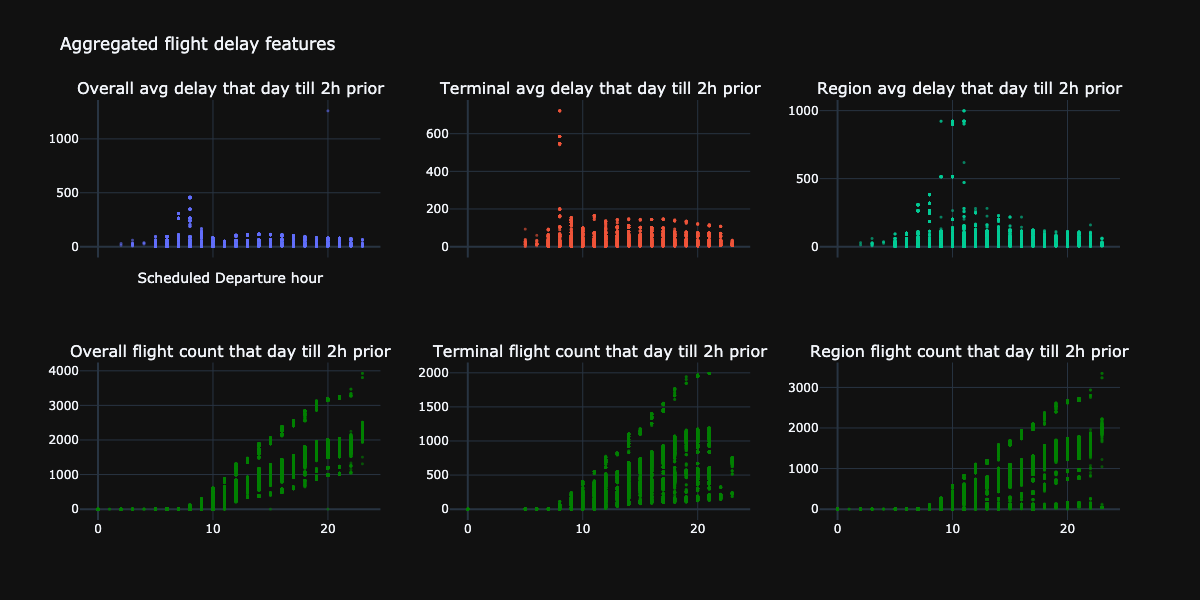

In [28]:
# List of aggregated feature names and titles for the subplots
avg_features = [
    "daily_2h_prior_avg_delay_overall", 
    "daily_2h_prior_avg_delay_terminal", 
    "daily_2h_prior_avg_delay_region", 
]
avg_titles = [
    "Overall avg delay that day till 2h prior", 
    "Terminal avg delay that day till 2h prior", 
    "Region avg delay that day till 2h prior", 
]

count_features = [
    "daily_2h_prior_count_overall", 
    "daily_2h_prior_count_terminal", 
    "daily_2h_prior_count_region", 
]
count_titles = [
    "Overall flight count that day till 2h prior", 
    "Terminal flight count that day till 2h prior", 
    "Region flight count that day till 2h prior", 
]

# Create a subplot grid: 2 rows, 4 columns
fig = make_subplots(rows=2, cols=3,
                    subplot_titles=avg_titles + count_titles,
                    shared_xaxes=True)

# Row 1: Aggregated Average Delays
for i, feature in enumerate(avg_features):
    row = 1
    col = i + 1
    fig.add_trace(
        go.Scatter(
            x=df_merged_copy['hour'],
            y=df_merged_copy[feature],
            mode='markers',
            marker=dict(size=3, opacity=0.6),
            name=feature,
            showlegend=False
        ),
        row=row, col=col
    )
    
# Row 2: Aggregated Counts
for i, feature in enumerate(count_features):
    row = 2
    col = i + 1
    fig.add_trace(
        go.Scatter(
            x=df_merged_copy['hour'],
            y=df_merged_copy[feature],
            mode='markers',
            marker=dict(size=3, opacity=0.6, color='green'),
            name=feature,
            showlegend=False
        ),
        row=row, col=col
    )

# Update layout
fig.update_layout(
    height=600,
    width=1200,
    title_text="Aggregated flight delay features",
    xaxis_title="Scheduled Departure hour"
)

fig.show()

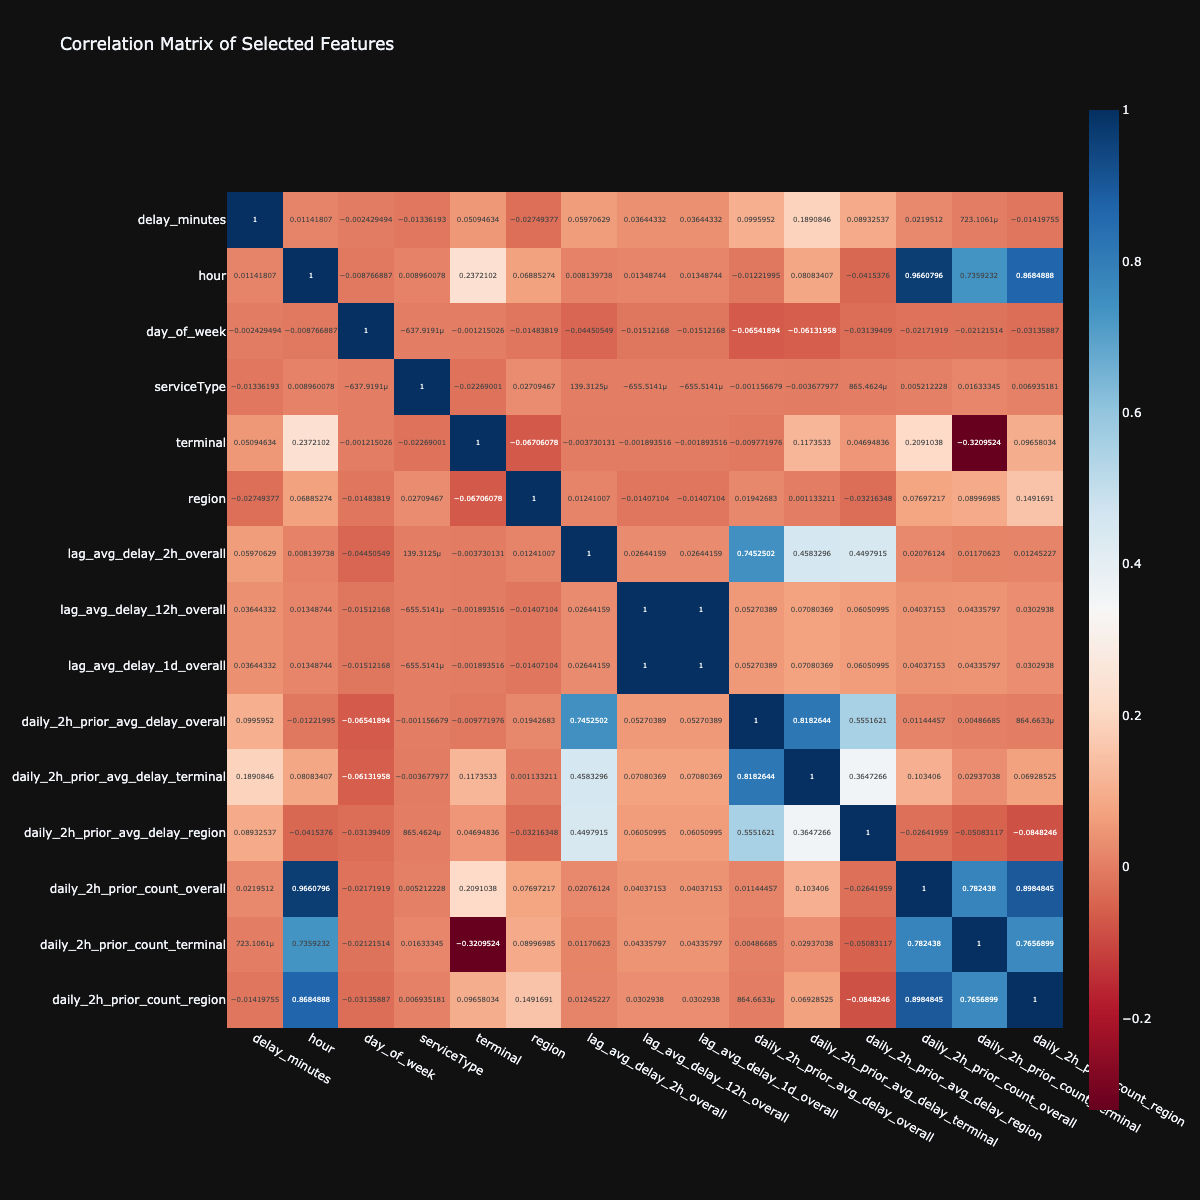

In [29]:
static_features1 = ['delay_minutes', 'hour', 'day_of_week']

# convert some categorical features to numerical
# df_merged_copy['terminal'] = pd.Categorical(df_merged['terminal']).codes
df_merged_copy['serviceType'] = pd.Categorical(df_merged['serviceType']).codes
df_merged_copy['region'] = pd.Categorical(df_merged['region']).codes

# combine features to a single list
full_static_features = static_features1 + static_features

# combine aggregated features to the list
num_features = full_static_features + lag_features + agg_features

# plot correlation matrix
corr_matrix = df_merged_copy[num_features].corr()

fig4 = px.imshow(
    corr_matrix,
    text_auto=True,
    color_continuous_scale="RdBu",
    title="Correlation Matrix of Selected Features"
)
fig4.update_layout(width=1200, height=1200)
fig4.show()

In [30]:
corr_matrix = df_merged_copy[num_features].corr()
corr_pairs = corr_matrix.unstack().sort_values(kind="quicksort", ascending=False)

top_corr_pairs = corr_pairs[corr_pairs.index.get_level_values(0) != corr_pairs.index.get_level_values(1)].head(25)
print("Top 25 Feature Correlations:")
print(top_corr_pairs)

Top 25 Feature Correlations:
lag_avg_delay_1d_overall           lag_avg_delay_12h_overall            1.000000
lag_avg_delay_12h_overall          lag_avg_delay_1d_overall             1.000000
daily_2h_prior_count_overall       hour                                 0.966080
hour                               daily_2h_prior_count_overall         0.966080
daily_2h_prior_count_overall       daily_2h_prior_count_region          0.898484
daily_2h_prior_count_region        daily_2h_prior_count_overall         0.898484
hour                               daily_2h_prior_count_region          0.868489
daily_2h_prior_count_region        hour                                 0.868489
daily_2h_prior_avg_delay_terminal  daily_2h_prior_avg_delay_overall     0.818264
daily_2h_prior_avg_delay_overall   daily_2h_prior_avg_delay_terminal    0.818264
daily_2h_prior_count_terminal      daily_2h_prior_count_overall         0.782438
daily_2h_prior_count_overall       daily_2h_prior_count_terminal        0.782438

## Target definition
### Since the flight state is designated as delayed if the delay is more than 10 minutes, we will follow the same.
### Create a binary delay class where the label is 0 if the delay is less than or equal to 10 minutes and 1 if more than 10 minutes

In [31]:
df_merged_copy['delay_target'] = df_merged_copy['delay_minutes'].apply(lambda x: 0 if x <= 10 else 1)

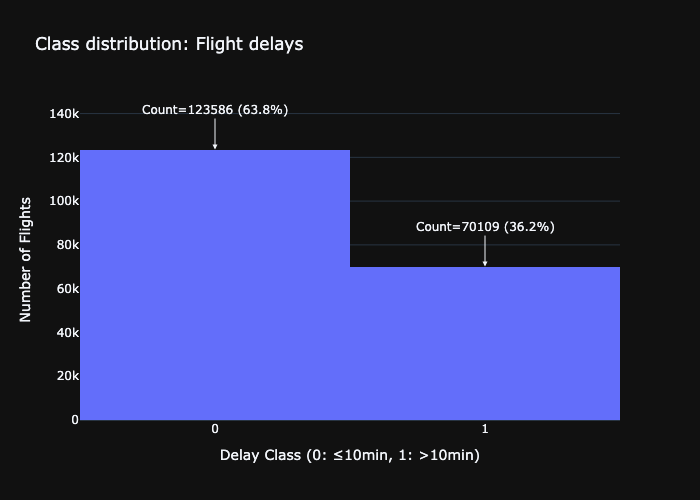

In [32]:
fig = px.histogram(
    df_merged_copy,
    x="delay_target",
    title="Class distribution: Flight delays",
    labels={"delay_target": "Delay class (0: ≤10min, 1: >10min)", "count": "Number of flights"},
    histnorm=None
)

class_counts = df_merged_copy["delay_target"].value_counts().sort_index()
annotations = [
    dict(
        x=cls,
        y=count,
        text=f"Count={count}\n({count/len(df_merged_copy)*100:.1f}%)",
        showarrow=True,
        arrowhead=2,
        ax=0,
        ay=-40
    )
    for cls, count in class_counts.items()
]

fig.update_layout(
    xaxis=dict(dtick=1),
    xaxis_title="Delay Class (0: ≤10min, 1: >10min)",
    yaxis_title="Number of Flights",
    width=700,
    annotations=annotations
)

fig.show()

In [33]:
# save the merged csv
df_merged_copy.to_csv(f"{DATASET_FOLDER}/flights_with_features.csv", index=False)